In [1]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))
from sparkdl import readImages
from pyspark.sql.functions import lit

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_dir = "hdfs:///flower-classify/flowers"

#Read images and Create training & test DataFrames for transfer learning
daisy_df = readImages(img_dir + "/daisy").withColumn("label", lit(0))
dandelion_df = readImages(img_dir + "/dandelion").withColumn("label", lit(1))
#roses_df = readImages(img_dir + "/roses").withColumn("label", lit(2))
#sunflowers_df = readImages(img_dir + "/sunflowers").withColumn("label", lit(3))
#tulips_df = readImages(img_dir + "/tulips").withColumn("label", lit(4))
print("DATA READ.")

daisy_train, daisy_test = daisy_df.randomSplit([0.6, 0.4])
dandelion_train, dandelion_test = dandelion_df.randomSplit([0.6, 0.4])
#roses_train, roses_test = roses_df.randomSplit([0.6, 0.4])
#sunflowers_train, sunflowers_test = sunflowers_df.randomSplit([0.6, 0.4])
#tulips_train, tulips_test = tulips_df.randomSplit([0.6, 0.4])
print("DATA SPLITTED.")

#dataframe for training a classification model
train_df = daisy_train.unionAll(dandelion_train)#.unionAll(roses_train).unionAll(sunflowers_train).unionAll(tulips_train)
print("TRAIN DF PREPARED.")

#dataframe for testing the classification model
test_df = daisy_test.unionAll(dandelion_test)#.unionAll(roses_test).unionAll(sunflowers_test).unionAll(tulips_test)
print("TEST DF PREPARED.")

DATA READ.
DATA SPLITTED.
TRAIN DF PREPARED.
TEST DF PREPARED.


In [3]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=5, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])
p_model = p.fit(train_df)

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [4]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df = p_model.transform(test_df)
df.cache()
df.show()
predictionAndLabels = df.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Training set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            filePath|               image|label|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|hdfs://student11:...|[RGB,213,320,3,[B...|    0|[0.0,0.2265879362...|[2.25942931673487...|[0.90546079098192...|       0.0|
|hdfs://student11:...|[RGB,240,212,3,[B...|    0|[0.0,1.1158411502...|[-0.8296690879589...|[0.30371504433316...|       1.0|
|hdfs://student11:...|[RGB,334,500,3,[B...|    0|[0.77314871549606...|[2.20057991653395...|[0.90030157548963...|       0.0|
|hdfs://student11:...|[RGB,240,240,3,[B...|    0|[0.47051167488098...|[2.06474047902429...|[0.88742860985111..

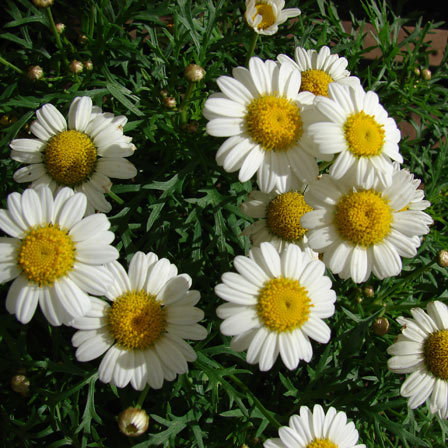

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
image_URL = "http://cdn2.stylecraze.com/wp-content/uploads/2013/11/Argyranthemum-Frutescens-Comet-White.jpg"
image_path = "/home/hduser/image.jpg"
image_hdfs_path = "hdfs:///flower-classify/tmp/image.jpg"

import urllib
urllib.urlretrieve (image_URL, image_path)
Image(filename = image_path, width=400, height=400)

In [6]:
%%bash
hdfs dfs -copyFromLocal -f /home/hduser/image.jpg /flower-classify/tmp/

In [7]:
test_df = readImages(image_hdfs_path)
predictions = p_model.transform(test_df)
predictions.show()


INFO:tensorflow:Froze 376 variables.
Converted 376 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|            filePath|               image|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|hdfs://student11:...|[RGB,448,448,3,[B...|[0.81001567840576...|[2.67290116782074...|[0.93540853980024...|       0.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+

